Raw dataset: DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

Sample:
{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}

Data size: 1629 182 453
Label distribution (train):
 label
1    0.614
2    0.252
0    0.134
Name: proportion, dtype: float64

Loading pretrained model: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Using device: GPU

Evaluating VALID set...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



[VALID] Accuracy=0.1319 | Macro-F1=0.0777
              precision    recall  f1-score   support

           0     0.1319    1.0000    0.2330        24
           1     0.0000    0.0000    0.0000       112
           2     0.0000    0.0000    0.0000        46

    accuracy                         0.1319       182
   macro avg     0.0440    0.3333    0.0777       182
weighted avg     0.0174    0.1319    0.0307       182


Evaluating TEST set...


/home/svu/e1539072/myenvs/ml310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/svu/e1539072/myenvs/ml310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/svu/e1539072/myenvs/ml310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize


[TEST] Accuracy=0.1347 | Macro-F1=0.0791
              precision    recall  f1-score   support

           0     0.1347    1.0000    0.2374        61
           1     0.0000    0.0000    0.0000       278
           2     0.0000    0.0000    0.0000       114

    accuracy                         0.1347       453
   macro avg     0.0449    0.3333    0.0791       453
weighted avg     0.0181    0.1347    0.0320       453



/home/svu/e1539072/myenvs/ml310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/svu/e1539072/myenvs/ml310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/svu/e1539072/myenvs/ml310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

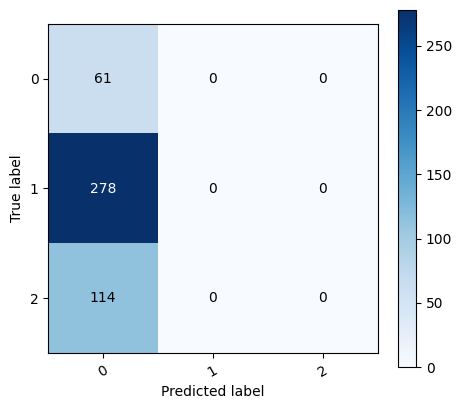


BASELINE RESULTS SUMMARY
Method: roberta-base (pretrained, no fine-tuning)

Data split:
  Train: 1629
  Valid: 182
  Test:  453

Validation metrics:
  Accuracy:  0.1319
  Macro-F1:  0.0777

Test metrics:
  Accuracy:  0.1347
  Macro-F1:  0.0791

Label order: [0, 1, 2]


In [1]:
# ============================================================
# Financial PhraseBank Baseline
# RoBERTa-base (pretrained, no fine-tuning)
# ============================================================

from datasets import load_dataset
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
import random
import torch

random.seed(42)
torch.manual_seed(42)

# ============================================================
# Load dataset (Parquet format)
# ============================================================
parquet_path = "hf://datasets/takala/financial_phrasebank@refs/convert/parquet/sentences_allagree/train/*.parquet"

raw = load_dataset("parquet", data_files={"train": parquet_path})
print("Raw dataset:", raw)
print("\nSample:")
print(raw["train"][0])

# ============================================================
# Split into train / valid / test
# ============================================================
dataset_split = raw["train"].train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
tmp = dataset_split["train"].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")

train_ds = tmp["train"]
valid_ds = tmp["test"]
test_ds = dataset_split["test"]

train_df = pd.DataFrame({"text": train_ds["sentence"], "label": train_ds["label"]})
valid_df = pd.DataFrame({"text": valid_ds["sentence"], "label": valid_ds["label"]})
test_df = pd.DataFrame({"text": test_ds["sentence"], "label": test_ds["label"]})

print("\nData size:", len(train_df), len(valid_df), len(test_df))
print("Label distribution (train):\n", train_df["label"].value_counts(normalize=True).round(3))

# ============================================================
# Load pretrained RoBERTa-base model (no fine-tuning)
# ============================================================
model_name = "roberta-base"
print(f"\nLoading pretrained model: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Financial sentiment: negative, neutral, positive
    ignore_mismatched_sizes=True
)

# Set device
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

# Create pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

# ============================================================
# Prediction function
# ============================================================
def predict_batch(texts, batch_size=16):
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        results = classifier(batch, truncation=True, max_length=512)
        predictions.extend(results)
    return predictions

# ============================================================
# Evaluation function
# ============================================================
def evaluate_split(name, df):
    print(f"\nEvaluating {name} set...")
    predictions = predict_batch(df["text"].tolist())
    
    # Extract predicted labels
    pred_labels = [int(pred["label"].split("_")[-1]) for pred in predictions]
    true_labels = df["label"].tolist()
    
    acc = accuracy_score(true_labels, pred_labels)
    f1m = f1_score(true_labels, pred_labels, average="macro")
    
    print(f"\n[{name}] Accuracy={acc:.4f} | Macro-F1={f1m:.4f}")
    print(classification_report(true_labels, pred_labels, digits=4))
    
    return true_labels, pred_labels, acc, f1m

y_val, p_val, val_acc, val_f1 = evaluate_split("VALID", valid_df)
y_tst, p_tst, tst_acc, tst_f1 = evaluate_split("TEST", test_df)

# ============================================================
# Confusion matrix visualization
# ============================================================
labels_order = sorted(list(pd.unique(
    pd.concat([train_df["label"], valid_df["label"], test_df["label"]])
)))
cm = confusion_matrix(y_tst, p_tst, labels=labels_order)

fig, ax = plt.subplots(figsize=(4.8, 4.2))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=labels_order, yticklabels=labels_order,
       ylabel="True label", xlabel="Predicted label")
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
thr = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center",
            color="white" if cm[i, j] > thr else "black")
fig.tight_layout()
plt.show()

# ============================================================
# Print final results summary
# ============================================================
print("\n" + "="*60)
print("BASELINE RESULTS SUMMARY")
print("="*60)
print(f"Method: {model_name} (pretrained, no fine-tuning)")
print(f"\nData split:")
print(f"  Train: {len(train_df)}")
print(f"  Valid: {len(valid_df)}")
print(f"  Test:  {len(test_df)}")
print(f"\nValidation metrics:")
print(f"  Accuracy:  {val_acc:.4f}")
print(f"  Macro-F1:  {val_f1:.4f}")
print(f"\nTest metrics:")
print(f"  Accuracy:  {tst_acc:.4f}")
print(f"  Macro-F1:  {tst_f1:.4f}")
print(f"\nLabel order: {labels_order}")
print("="*60)